Created dataset with final X shape: (60, 198) and y shape: (60, 28)

Feature matrix now includes one-hot encoded geo columns:
           name geo  geo_IN  geo_WW
0      Agnipath  IN       1       0
1        Animal  WW       0       1
2         Apple  WW       0       1
3          Area  WW       0       1
4  Barbenheimer  WW       0       1

Train set size: 45, Test set size: 15

Model saved successfully as 'virality_predictor_geo_v1.pkl'

Mean Absolute Error on Test Set: 16.19


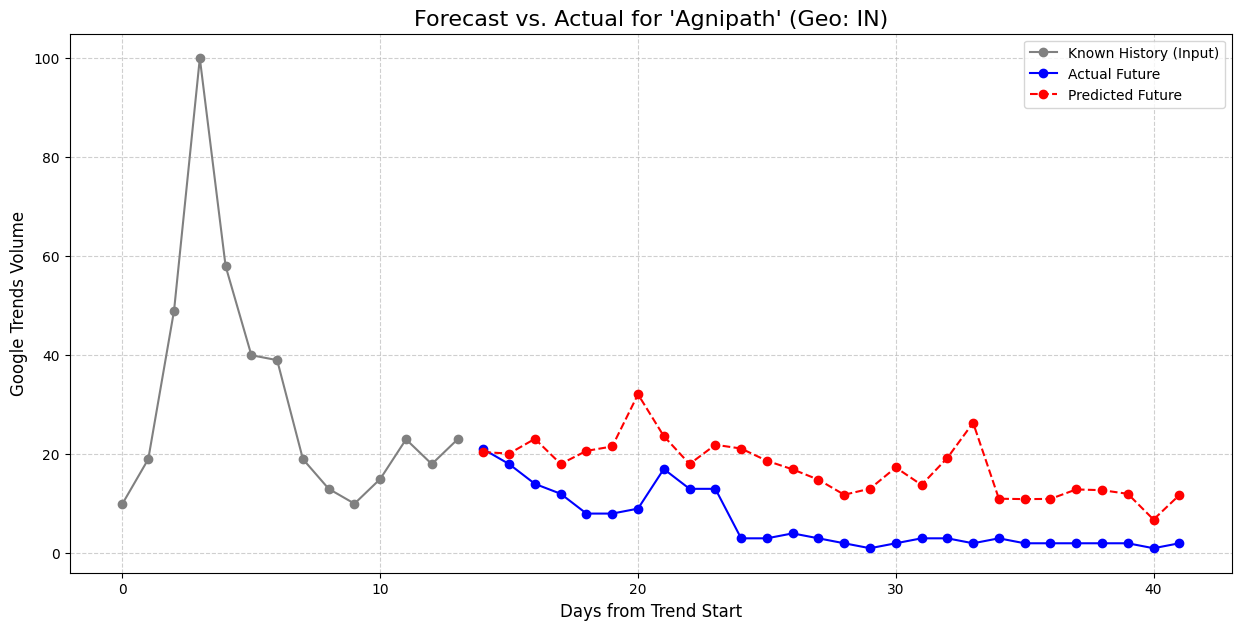

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --- Reload Feature-Engineered Data ---
# This code assumes you've run the feature engineering script and have the `processed_trends` dictionary.
# In a real script, you'd load the individual processed files.
# For this example, let's assume `processed_trends` is available.

# --- Configuration ---
N = 14  # Use the first 14 days of data to predict
M = 28  # Predict the next 28 days

X_list = []
y_list = []
trend_info_list = [] # Store name and geo for each row

# Let's re-run the processing loop to get access to the filename for geo info
DATA_DIR = '../data'
all_files = [f for f in os.listdir(DATA_DIR) if f.endswith('_gtrends.csv')]
processed_trends = {} # Re-populating for this script
for file in all_files:
    # ... (exact same feature engineering code as Step 2) ...
    # This is inefficient but makes the script self-contained.
    # A better way would be to save processed files and load them here.
    df = pd.read_csv(os.path.join(DATA_DIR, file), index_col='date', parse_dates=True)
    df = df[['gtrends_volume']]
    for lag in [1, 2, 3, 7, 14]: df[f'vol_lag_{lag}'] = df['gtrends_volume'].shift(lag)
    for window in [3, 7, 14]:
        df[f'vol_rolling_mean_{window}'] = df['gtrends_volume'].rolling(window=window).mean()
        df[f'vol_rolling_std_{window}'] = df['gtrends_volume'].rolling(window=window).std()
    df['vol_diff_1'] = df['gtrends_volume'].diff(1)
    df['vol_accel_1'] = df['vol_diff_1'].diff(1)
    df.fillna(0, inplace=True)
    processed_trends[file] = df


for filename, df in processed_trends.items():
    # --- Extract Geo from Filename ---
    if '_IN_gtrends.csv' in filename:
        geo = 'IN'
    else:
        geo = 'WW' # Assume Worldwide otherwise
    
    trend_name = filename.split('_')[0]

    try:
        start_idx_pos = np.where(df['gtrends_volume'] > 5)[0][0]
    except IndexError:
        continue

    if len(df) > start_idx_pos + N + M:
        trend_slice = df.iloc[start_idx_pos:]
        
        x_features = trend_slice.iloc[0:N].values.flatten()
        y_target = trend_slice.iloc[N : N + M]['gtrends_volume'].values
        
        if y_target.sum() > 0:
            X_list.append(x_features)
            y_list.append(y_target)
            trend_info_list.append({'name': trend_name, 'geo': geo})

# --- Convert to NumPy Arrays and Create Geo Features ---
X_temporal = np.array(X_list)
y = np.array(y_list)
trend_info_df = pd.DataFrame(trend_info_list)

# Use pandas to easily One-Hot Encode the 'geo' column
geo_features = pd.get_dummies(trend_info_df['geo'], prefix='geo').astype(int)

# --- Combine Temporal and Categorical Features ---
# We add the new geo features to our existing feature matrix X
X = np.concatenate([X_temporal, geo_features.values], axis=1)

print(f"Created dataset with final X shape: {X.shape} and y shape: {y.shape}")
print("\nFeature matrix now includes one-hot encoded geo columns:")
print(pd.concat([trend_info_df, geo_features], axis=1).head())

# --- Model Training and Evaluation (code is now the same as before) ---
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

X_train, X_test, y_train, y_test, trend_info_train, trend_info_test = train_test_split(
    X, y, trend_info_df, test_size=0.25, random_state=42
)

print(f"\nTrain set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

model = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42
)
multi_output_model = MultiOutputRegressor(model)
multi_output_model.fit(X_train, y_train)

joblib.dump(multi_output_model, os.path.join(MODELS_DIR, 'virality_predictor_geo_v1.pkl'))
print("\nModel saved successfully as 'virality_predictor_geo_v1.pkl'")

y_pred = multi_output_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error on Test Set: {mae:.2f}")

# --- Visual Evaluation ---
test_case_index = 0
prediction_curve = y_pred[test_case_index]
actual_curve = y_test[test_case_index]
test_case_name = trend_info_test.iloc[test_case_index]['name']
test_case_geo = trend_info_test.iloc[test_case_index]['geo']

# Extract history curve from the temporal part of X_test
num_temporal_features = X_temporal.shape[1]
num_features_per_day = num_temporal_features // N
history_flat = X_test[test_case_index, :num_temporal_features]
history_reshaped = history_flat.reshape(N, num_features_per_day)
history_curve = history_reshaped[:, 0]

plt.figure(figsize=(15, 7))
plt.plot(range(0, N), history_curve, 'o-', color='gray', label='Known History (Input)')
plt.plot(range(N, N + M), actual_curve, 'o-', color='blue', label='Actual Future')
plt.plot(range(N, N + M), prediction_curve, 'o--', color='red', label='Predicted Future')
plt.title(f"Forecast vs. Actual for '{test_case_name}' (Geo: {test_case_geo})", fontsize=16)
plt.xlabel("Days from Trend Start", fontsize=12)
plt.ylabel("Google Trends Volume", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Starting Step 1: Simplified Feature Engineering...
  -> Processed 69 trends with simplified features.

Starting Step 2: Creating the Model Dataset...
  -> Skipping Area_51_raid: Future data (target) is too flat.
  -> Skipping James_Webb_Telescope: Future data (target) is too flat.
  -> Skipping Paytm_crisis: Future data (target) is too flat.
  -> Skipping Rahul_Gandhi_disqualification: Future data (target) is too flat.

Created dataset with final X shape: (58, 128) and y shape: (58, 28)

Starting Step 3: Model Training with Regularization...
  -> Train set size: 43, Test set size: 15

Model saved successfully as 'virality_predictor_geo_v2_regularized.pkl'

Starting Step 4: Evaluation...

Mean Absolute Error on Test Set: 15.49


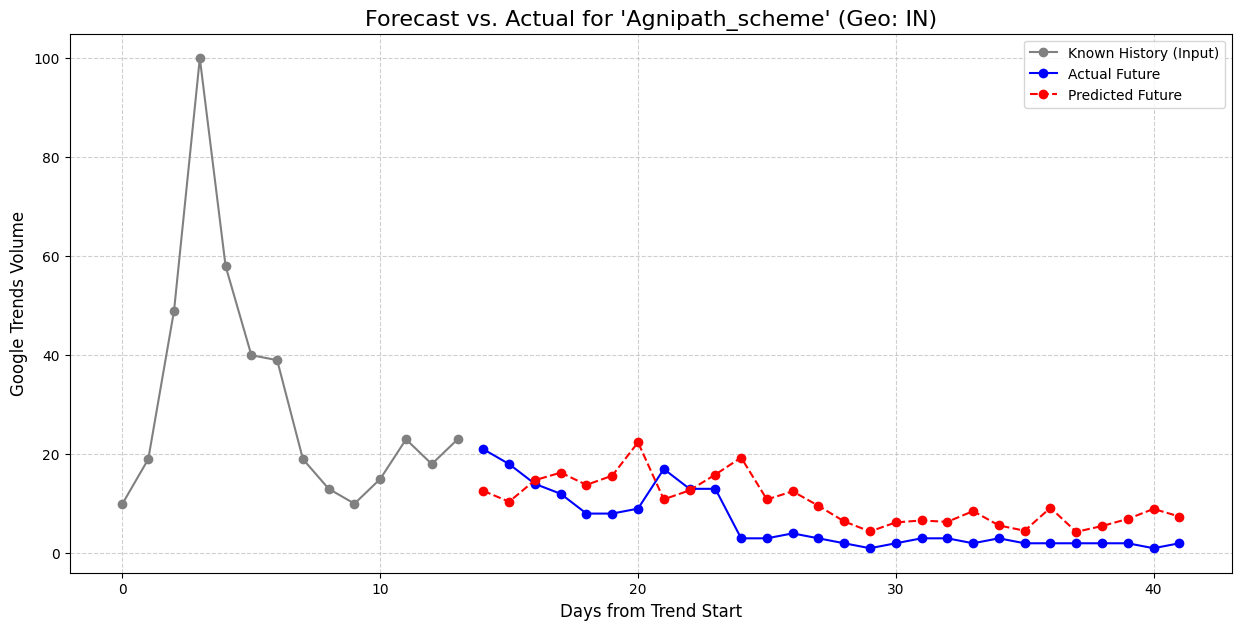

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ==============================================================================
# Step 1: Feature Engineering (Simplified for Smoother Predictions)
# ==============================================================================
print("Starting Step 1: Simplified Feature Engineering...")

DATA_DIR = '../data'
all_files = [f for f in os.listdir(DATA_DIR) if f.endswith('_gtrends.csv')]
processed_trends = {}

for file in all_files:
    # --- START OF MODIFIED FEATURE ENGINEERING ---
    df = pd.read_csv(os.path.join(DATA_DIR, file), index_col='date', parse_dates=True)
    
    # We only care about the volume, drop the 'is_partial' flag
    if 'gtrends_volume' in df.columns:
        df = df[['gtrends_volume']]
    else:
        # Handle cases where the keyword might not be the column name initially
        df = df.rename(columns={df.columns[0]: 'gtrends_volume'})[['gtrends_volume']]
        
    # We will simplify the features to make the model smoother
    # Focus on longer-term signals rather than daily noise

    # Rolling Window Features (KEEP - these are good smoothing features)
    for window in [7, 14]: # REMOVED the noisy 3-day window
        df[f'vol_rolling_mean_{window}'] = df['gtrends_volume'].rolling(window=window).mean()
        df[f'vol_rolling_std_{window}'] = df['gtrends_volume'].rolling(window=window).std()

    # Lag Features (KEEP - essential for time-series context)
    for lag in [1, 7, 14]: # REMOVED short-term lags 2, 3
        df[f'vol_lag_{lag}'] = df['gtrends_volume'].shift(lag)

    # Difference Features (SIMPLIFY - focus on weekly change, not daily)
    df['vol_diff_7'] = df['gtrends_volume'].diff(7) # REMOVED vol_diff_1 and accel_1

    df.fillna(0, inplace=True)
    processed_trends[file] = df
    # --- END OF MODIFIED FEATURE ENGINEERING ---

print(f"  -> Processed {len(processed_trends)} trends with simplified features.")

# ==============================================================================
# Step 2: Create the Model Dataset (X, y) with Geo-Features
# ==============================================================================
print("\nStarting Step 2: Creating the Model Dataset...")

# --- Configuration ---
N = 14  # Use the first 14 days of data to predict
M = 28  # Predict the next 28 days

X_list = []
y_list = []
trend_info_list = [] # Store name and geo for each row

for filename, df in processed_trends.items():
    # --- Extract Geo from Filename ---
    if '_IN_gtrends.csv' in filename:
        geo = 'IN'
    else:
        geo = 'WW' # Assume Worldwide otherwise
    
    # A robust way to get the trend name from filename like 'My_Trend_WW_gtrends.csv'
    trend_name = '_'.join(filename.split('_')[:-2])

    try:
        # Find the first day the trend is "real" (e.g., volume > 5)
        start_idx_pos = np.where(df['gtrends_volume'] > 5)[0][0]
    except IndexError:
        print(f"  -> Skipping {trend_name}: Did not find a start point with volume > 5.")
        continue

    # Ensure there's enough data for one full sample (N days history + M days future)
    if len(df) > start_idx_pos + N + M:
        trend_slice = df.iloc[start_idx_pos:]
        
        # Create X: first N days of ALL engineered features, flattened
        x_features = trend_slice.iloc[0:N].values.flatten()
        # Create y: gtrends_volume for the NEXT M days
        y_target = trend_slice.iloc[N : N + M]['gtrends_volume'].values
        
        # Check if the target has meaningful data (not all zeros)
        if y_target.sum() > 20: # Stricter filter for more meaningful trends
            X_list.append(x_features)
            y_list.append(y_target)
            trend_info_list.append({'name': trend_name, 'geo': geo})
        else:
            print(f"  -> Skipping {trend_name}: Future data (target) is too flat.")

# --- Convert to NumPy Arrays and Create Geo Features ---
X_temporal = np.array(X_list)
y = np.array(y_list)
trend_info_df = pd.DataFrame(trend_info_list)

# Use pandas to easily One-Hot Encode the 'geo' column
geo_features = pd.get_dummies(trend_info_df['geo'], prefix='geo').astype(int)

# Combine Temporal and Categorical Features
X = np.concatenate([X_temporal, geo_features.values], axis=1)

print(f"\nCreated dataset with final X shape: {X.shape} and y shape: {y.shape}")

# ==============================================================================
# Step 3: Model Training with Regularization
# ==============================================================================
print("\nStarting Step 3: Model Training with Regularization...")

MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Split the data for training and testing
X_train, X_test, y_train, y_test, trend_info_train, trend_info_test = train_test_split(
    X, y, trend_info_df, test_size=0.25, random_state=42
)

print(f"  -> Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- START OF MODIFIED MODEL DEFINITION ---
# Regularize the XGBoost model to make it less complex and prevent it from fitting to noise.
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500,          
    learning_rate=0.05,
    max_depth=4,               # CHANGED: Reduced depth slightly from 5 to 4
    subsample=0.8,             
    colsample_bytree=0.8,      
    gamma=0.5,                 # ADDED: Makes it harder for the model to split nodes
    reg_lambda=1,              # ADDED: L2 regularization to penalize large weights
    random_state=42
)
# --- END OF MODIFIED MODEL DEFINITION ---

multi_output_model = MultiOutputRegressor(model)
multi_output_model.fit(X_train, y_train)

# Save the new, regularized model with a new version name
model_filename = 'virality_predictor_geo_v2_regularized.pkl'
joblib.dump(multi_output_model, os.path.join(MODELS_DIR, model_filename))
print(f"\nModel saved successfully as '{model_filename}'")


# ==============================================================================
# Step 4: Evaluation
# ==============================================================================
print("\nStarting Step 4: Evaluation...")

y_pred = multi_output_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error on Test Set: {mae:.2f}")

# --- Visual Evaluation ---
# Plot the first trend in our test set as an example
test_case_index = 0
prediction_curve = y_pred[test_case_index]
actual_curve = y_test[test_case_index]
test_case_name = trend_info_test.iloc[test_case_index]['name']
test_case_geo = trend_info_test.iloc[test_case_index]['geo']

# Extract history curve from the temporal part of X_test
num_temporal_features = X_temporal.shape[1]
num_features_per_day = num_temporal_features // N
history_flat = X_test[test_case_index, :num_temporal_features]
history_reshaped = history_flat.reshape(N, num_features_per_day)
# The first column is always the original 'gtrends_volume'
history_curve = history_reshaped[:, 0]

plt.figure(figsize=(15, 7))
plt.plot(range(0, N), history_curve, 'o-', color='gray', label='Known History (Input)')
plt.plot(range(N, N + M), actual_curve, 'o-', color='blue', label='Actual Future')
plt.plot(range(N, N + M), prediction_curve, 'o--', color='red', label='Predicted Future')

plt.title(f"Forecast vs. Actual for '{test_case_name}' (Geo: {test_case_geo})", fontsize=16)
plt.xlabel("Days from Trend Start", fontsize=12)
plt.ylabel("Google Trends Volume", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Creating fallback visual for the Streamlit app...
  -> Successfully saved fallback visual to: app\assets\fallback_chatgpt.png


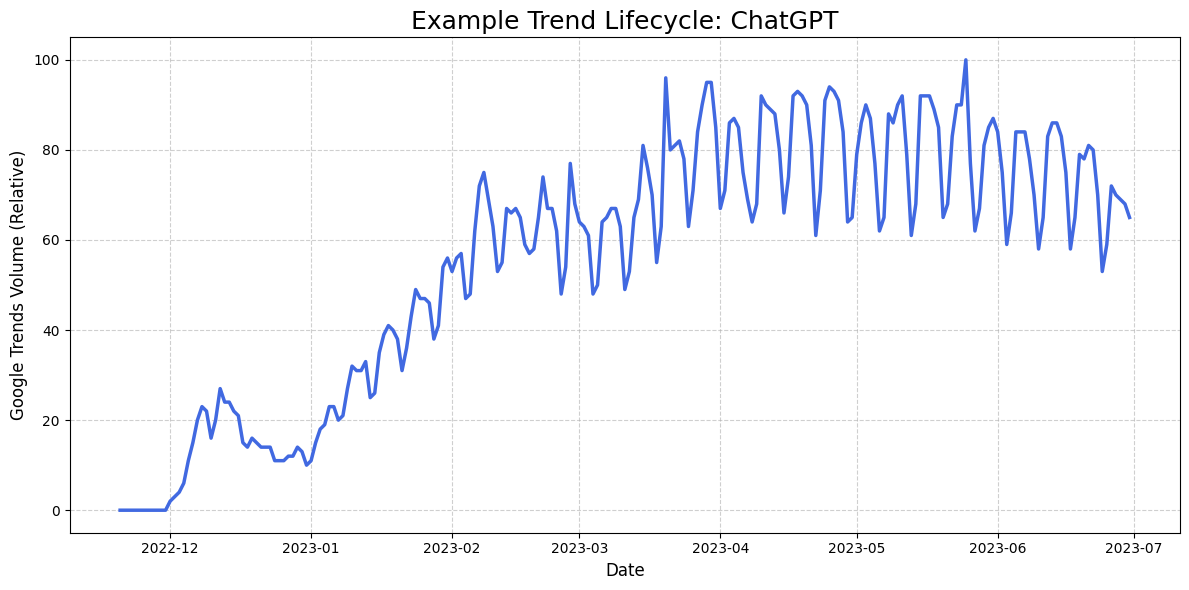

In [6]:
# ==============================================================================
# Final Step: Create a Fallback Visual for the Streamlit App
# ==============================================================================
print("\nCreating fallback visual for the Streamlit app...")

# --- Configuration ---
FALLBACK_KEYWORD = 'ChatGPT_WW_gtrends.csv'
FALLBACK_TITLE = 'Example Trend Lifecycle: ChatGPT'
ASSET_DIR = os.path.join('app', 'assets')
os.makedirs(ASSET_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(ASSET_DIR, 'fallback_chatgpt.png')

# --- Load the specific trend data ---
try:
    df_fallback = pd.read_csv(os.path.join('../data', FALLBACK_KEYWORD), index_col='date', parse_dates=True)
    
    # Isolate the most interesting part of the trend
    df_fallback = df_fallback['2022-11-01':'2023-06-30']
    
    # --- Create the plot ---
    plt.figure(figsize=(12, 6))
    plt.plot(df_fallback.index, df_fallback['gtrends_volume'], color='royalblue', linewidth=2.5)
    
    plt.title(FALLBACK_TITLE, fontsize=18)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Google Trends Volume (Relative)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Adjusts plot to prevent labels from being clipped

    # --- Save the plot to the app's asset folder ---
    plt.savefig(OUTPUT_PATH, dpi=150, bbox_inches='tight')
    
    print(f"  -> Successfully saved fallback visual to: {OUTPUT_PATH}")
    # plt.show() # Optional: uncomment to see the plot in the notebook

except FileNotFoundError:
    print(f"  -> ERROR: Could not find the data file '{FALLBACK_KEYWORD}' to create the fallback visual.")